# The Birthday Problem Goes Beyond Couples
So this week's Riddler Classic was a spin on a classic problem: The Birthday Problem.

>From Joel Lewis, this week’s Riddler Classic is a birthday puzzle for the ages:  
>The classic birthday problem asks about how many people need to be in a room together before you have better-than-even odds that at least two of them have the same birthday. Ignoring leap years, the answer is, paradoxically, only 23 people — fewer than you might intuitively think.  
>But Joel noticed something interesting about a well-known group of 100 people: In the U.S. Senate, three senators happen to share the same birthday of October 20: Kamala Harris, Brian Schatz and Sheldon Whitehouse.  
>And so Joel has thrown a new wrinkle into the classic birthday problem. How many people do you need to have better-than-even odds that at least three of them have the same birthday? (Again, ignore leap years.)

https://fivethirtyeight.com/features/who-wants-to-be-a-riddler-millionaire/

## The Classic Birthday Problem
Probability of no match:
$$m = \frac{365!}{(365-n)!365^n}.$$
Then probability of at least one match would be: $$1 - m.$$

In [2]:
def two(n):
    return 1-factorial_division(365,365-n)/Decimal(365**n)

## 3 Matching Birthdays

The problem with at least 3-matching birthdays is that the calculation is not as simple and elegant as it is with 2 matching birthdays.  
Below is the code I used to calculate the possibility of 3 matching birthdays.  
In a nutshell, given a population of size $n$, on top of all possibilities where all $n$ birthdays are different you need to calculate all possibilities where there are *exactly* two matches to find the possibility that there are no matching triples.

[Hector Pefo](https://twitter.com/HectorPefo) has provided a much better [exposition](https://hectorpefo.github.io/2019-10-06-Three-Birthdays/) of this.

In [4]:
# Note al:l helper functions and imports are below for ease of presentation
def three(n):
    summ = 0

    i = 0 # Number of couples
    while i <= n/2:
        non_same = n - 2*i
        sames_factor = factorial_division(365,365-i)/Decimal(365**(2*i))
        non_sames_factor = factorial_division(365-i,365-n+i)/Decimal(365**(non_same))
        count = factorial_division(n,non_same)/Decimal(2**(i)*factorial(i))
        summ += count*sames_factor*non_sames_factor
        i+= 1    
    return 1 - summ

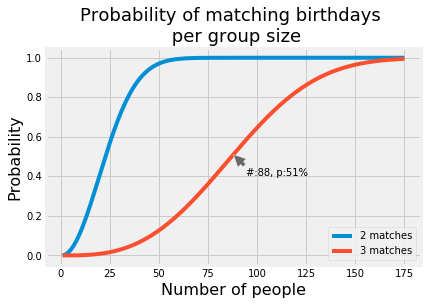

In [5]:
fig, ax = plt.subplots()
x = [i+1 for i in range(175)]
y = [two(i) for i in x]
z = [three(i) for i in x]
ax.plot(x, y, label='2 matches')
ax.plot(x, z, label='3 matches')
ax.annotate('#:88, p:51%',
            xy=(88, 0.51), xycoords='data',
            xytext=(0.617, 0.45), textcoords='axes fraction',
            arrowprops=dict(facecolor='dimgrey', shrink=0.001),
            horizontalalignment='center', verticalalignment='top')
plt.ylabel('Probability', fontsize=16)
plt.xlabel('Number of people',fontsize=16)
plt.title('Probability of matching birthdays \n per group size',fontsize=18)
ax.legend()
plt.show()

## Solving for *n*

Well, can we solve this "Birthday Problem" once and for all?

In [6]:
def generalized(n,g,d=365):
    '''
    n = population
    g = the tuple that we want to ensure doesn't exist
        so we want to search for tuples from g - 1 and down
    d = number of available days to choose from
    '''
    res = 0 
    m = g - 1 # m-tuples and lower are the tuples we want to exclude
    
    if m == 1:
        # Calculate the probability that all dates are distinct
        res += factorial_division(d, d-n)/Decimal(365**n)
        
    elif m > 1:
        # What to do if we are looking for couples and above?
        # Loop over different numbers of m-tuples,
        # starting with 1 until n/m,
        # Put the remainder of dates in this same function,
        # with m - 1
        t = 1 # number of m-tuples
        while t <= n/m:
            # How many dates do we have in a tuple?
            in_a_tuple = m*t
            remainder = n - in_a_tuple
            
            # Probability for the tuples
            # E.g. 2 triples where d = 365
            # 365 ways to choose the first triple and 364 for the second
            # 365*364/365**6
            tuple_prob = factorial_division(d, d-t)/Decimal(365**in_a_tuple)
            
            # we also need to count the different ways
            # in which tuples are to be distributed
            count = (factorial_division(n, remainder)
                    /Decimal(factorial(m)**t*factorial(t)))
            
            # What to do with the remaining numbers that aren't in a tuple:
            # The general idea is to use recursion:
            # Apply the function on the remainder with g lowered by one,
            # and fewer days to choose from.
            remainder_prob = generalized(remainder,g-1,d-t)
            
            res += count*tuple_prob*remainder_prob
            
            t += 1 
        res += generalized(n,g-1,d)
        
    else:
        raise ValueError('m cannot less than 1.')
    
    return res

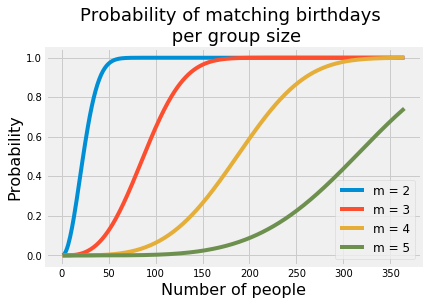

In [7]:
# As m gets larger it takes a significant
# amount of time to compute probabilities.
# So I calculated them elsewhere using 
# multiprocessing and dumped into a file.
with open('pr.pkl', 'rb') as f:
    probs = pickle.load(f)
fig, ax = plt.subplots()

x = [i+1 for i in range(365)]

for m,v in probs.items():
    plt.plot(x, v,label=f'm = {m}')
    
plt.ylabel('Probability', fontsize=16)
plt.xlabel('Number of people',fontsize=16)
plt.title('Probability of matching birthdays \n per group size',fontsize=18)
ax.legend(fontsize = 12)
plt.show()

In [1]:
#Helper Functions and imports
from decimal import Decimal
import pickle
from scipy.special import factorial
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('fivethirtyeight')

def factorial_division(num, denom):
    # Avoid ridiculously large numbers
    res = 1
    while num > denom:
        res *= Decimal(num)
        num -= 1
    return res